In [1]:
import torch
import torch.nn as nn
import librosa
import scipy
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
nsc = 6 * 256
hop = 256
nov = nsc - hop
n_mels = 256
fs = 44100/2
num_hidden = 512
K = 10

mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
print(mel_filters.shape)

(256, 769)


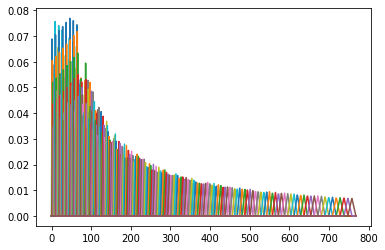

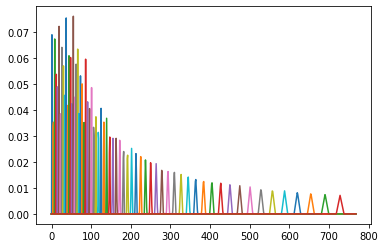

In [3]:
plt.plot(mel_filters.T)
plt.show()

plt.plot(mel_filters[::4].T)
plt.show()

In [4]:
data_dir = '../data'
file_list = glob.glob(data_dir + '/*')

In [5]:
# y, fs = librosa.core.load(file_list[0], sr=None)
y, fs = librosa.core.load(file_list[0])

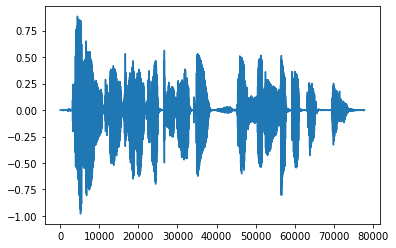

In [6]:
plt.plot(y)
plt.show()
ipd.Audio(y, rate=fs)

In [7]:
f, t, Sxx = scipy.signal.stft(y, fs=fs, window='hann', nperseg=nsc, noverlap=nov)
# Sxx = Sxx[1:, :]
Zxx = np.abs(Sxx)
log_spectrogram = 20 * np.log10(np.maximum(Zxx, 1e-8))
log_spectrogram_norm = (log_spectrogram + 160) / 160

mel_spectrogram = np.matmul(mel_filters, Zxx)
log_mel_spectrogram = 20 * np.log10(np.maximum(mel_spectrogram, 1e-8))
mel_input = (log_mel_spectrogram + 160) / 160

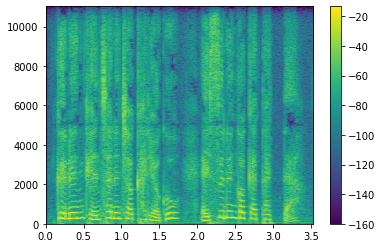

(769, 305)


In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.imshow(log_spectrogram, origin='reverse', extent=[0, t[-1], 0, f[-1]])
plt.colorbar()

# plt.ylim([0, 200])
ax.set_aspect('auto')

plt.show()

print(log_spectrogram.shape)

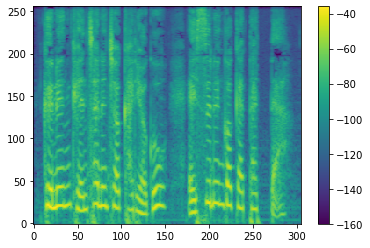

(256, 305)


In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.imshow(log_mel_spectrogram, origin='reverse')
plt.colorbar()

# plt.ylim([0, 200])
ax.set_aspect('auto')

plt.show()

print(mel_input.shape)

In [10]:
mel_input

Tier6 = mel_input[::2, :]
Tier6_not = mel_input[1::2, :]

Tier5 = Tier6_not[:, ::2]
Tier5_not = Tier6_not[:, 1::2]

Tier4 = Tier5_not[::2, :]
Tier4_not = Tier5_not[1::2, :]

Tier3 = Tier4_not[:, ::2]
Tier3_not = Tier4_not[:, 1::2]

Tier2 = Tier3_not[::2, :]
Tier1 = Tier3_not[1::2, :]

Tiers = [Tier1, Tier2, Tier3, Tier4, Tier5, Tier6]

# Tier6 = mel_input

# Tier5 = Tier6[::2, :]
# Tier5_not = Tier6[1::2, :]

# Tier4 = Tier5_not[:, ::2]
# Tier4_not = Tier5_not[:, 1::2]

# Tier3 = Tier4_not[::2, :]
# Tier3_not = Tier4_not[1::2, :]

# Tier2 = Tier3_not[:, ::2]
# Tier1 = Tier3_not[:, 1::2]

# Tiers = [Tier1, Tier2, Tier3, Tier4, Tier5, Tier6]

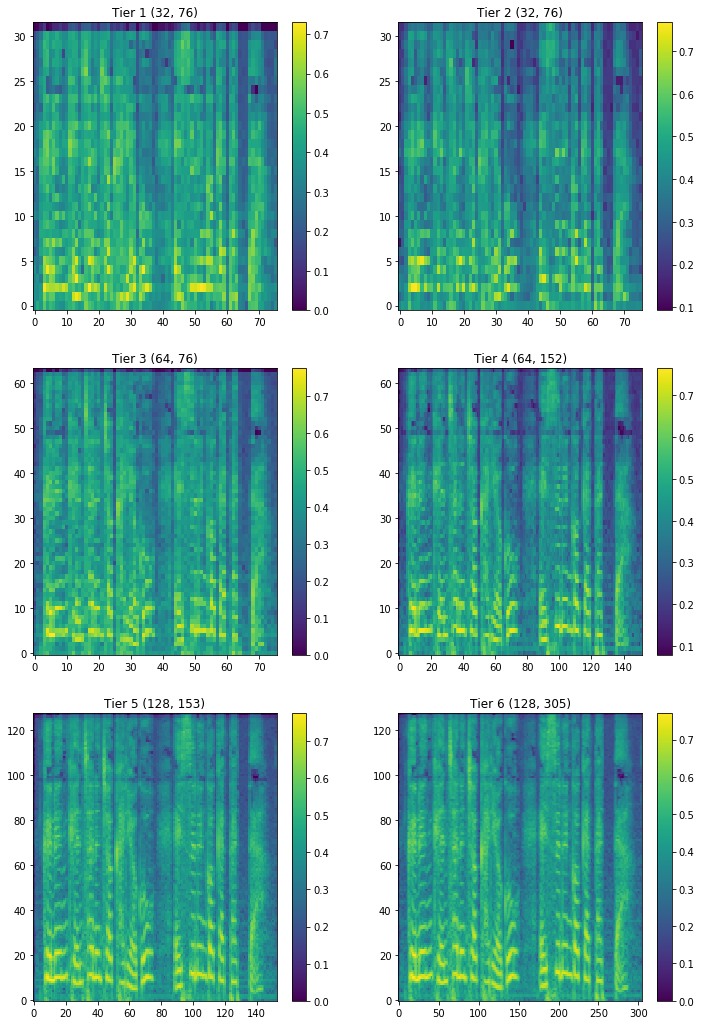

In [11]:
fig = plt.figure(figsize=(12, 18))

for i in range(0, 6):
    ax = fig.add_subplot(3, 2, i + 1)

    plt.imshow(Tiers[i], origin='reverse')
    plt.colorbar()
    
    ax.set_aspect('auto')
    ax.title.set_text('Tier {} {}'.format(i + 1, Tiers[i].shape))

plt.show()

In [12]:
tensor = torch.tensor(Tier1.T)

In [13]:
input_tensor = tensor.view([1, tensor.shape[0], tensor.shape[1], 1])

In [14]:
input_tensor.shape

torch.Size([1, 76, 32, 1])

In [15]:
input_tensor[:, :, :, 0].shape

torch.Size([1, 76, 32])

In [16]:
W_f_0 = nn.Linear(1, num_hidden)
W_t_0 = nn.Linear(1, num_hidden)
W_c_0 = nn.Linear(32, num_hidden)

In [17]:
h_f_0_ = W_f_0(input_tensor)
h_f_0 = torch.zeros(h_f_0_.shape)
h_f_0[:, :, 1:, :] = h_f_0_[:, :, :-1, :]
print('h_f_0: {}'.format(h_f_0.shape))

h_f_0: torch.Size([1, 76, 32, 512])


In [18]:
h_t_0_ = W_t_0(input_tensor)
h_t_0 = torch.zeros(h_t_0_.shape)
h_t_0[:, 1:, :, :] = h_t_0_[:, :-1, :, :]
print('h_t_0: {}'.format(h_t_0.shape))

h_t_0: torch.Size([1, 76, 32, 512])


In [19]:
h_c_0_ = W_c_0(input_tensor[:, :, :, 0])
h_c_0 = torch.zeros(h_c_0_.shape)
h_c_0[:, 1:, :] = h_c_0_[:, :-1, :]
print('h_c_0: {}'.format(h_c_0.shape))

h_c_0: torch.Size([1, 76, 512])


In [20]:
time_delayed_RNN_x = nn.GRU(input_size=num_hidden, hidden_size=num_hidden, batch_first=True)
time_delayed_RNN_y = nn.GRU(input_size=num_hidden, hidden_size=num_hidden, batch_first=True)
time_delayed_RNN_z = nn.GRU(input_size=num_hidden, hidden_size=num_hidden, batch_first=True)

W_t_1 = nn.Linear(3 * num_hidden, num_hidden)

centralized_RNN = nn.GRU(input_size=num_hidden, hidden_size=num_hidden, batch_first=True)

W_c_1 = nn.Linear(num_hidden, num_hidden)

frequency_delayed_RNN = nn.GRU(input_size=num_hidden, hidden_size=num_hidden, batch_first=True)

W_f_1 = nn.Linear(num_hidden, num_hidden)

In [21]:
outputs_x = list()

for i in range(h_t_0.shape[2]):
    output_x, _ = time_delayed_RNN_x(h_t_0[:, :, i, :])
    outputs_x.append(output_x)
    
h_t_1_x = torch.stack(outputs_x, 2)
print('h_t_1_x: {}'.format(h_t_1_x.shape))

outputs_y = list()
outputs_z = list()

for i in range(h_t_0.shape[1]):
    reverse_index = np.arange(h_t_0.shape[2] - 1, -1, -1)
    output_y, _ = time_delayed_RNN_y(h_t_0[:, i, :, :])
    output_z, _ = time_delayed_RNN_z(h_t_0[:, i, reverse_index, :])
    outputs_y.append(output_y)
    outputs_z.append(output_z[:, reverse_index, :])
    
h_t_1_y = torch.stack(outputs_y, 1)
h_t_1_z = torch.stack(outputs_z, 1)
print('h_t_1_y: {}'.format(h_t_1_y.shape))
print('h_t_1_z: {}'.format(h_t_1_z.shape))

h_t_1_x: torch.Size([1, 76, 32, 512])
h_t_1_y: torch.Size([1, 76, 32, 512])
h_t_1_z: torch.Size([1, 76, 32, 512])


In [22]:
h_t_1_ = torch.cat([h_t_1_x, h_t_1_y, h_t_1_z], 3)
print('h_t_1_: {}'.format(h_t_1_.shape))

h_t_1_w = W_t_1(h_t_1_)
print('h_t_1_w: {}'.format(h_t_1_w.shape))

h_t_1 = torch.add(h_t_1_w, h_t_0)
print('h_t_1: {}'.format(h_t_1.shape))

h_t_1_: torch.Size([1, 76, 32, 1536])
h_t_1_w: torch.Size([1, 76, 32, 512])
h_t_1: torch.Size([1, 76, 32, 512])


In [23]:
h_c_1_, _ = centralized_RNN(h_c_0)
print('h_c_1_: {}'.format(h_c_1_.shape))

h_c_1_w = W_c_1(h_c_1_)
print('h_c_1_w: {}'.format(h_c_1_w.shape))

h_c_1 = h_c_1_w + h_c_0
print('h_c_1: {}'.format(h_c_1.shape))

h_c_1_: torch.Size([1, 76, 512])
h_c_1_w: torch.Size([1, 76, 512])
h_c_1: torch.Size([1, 76, 512])


In [24]:
h_c_1_expand = h_c_1.view(h_c_1.shape[0], h_c_1.shape[1], 1, h_c_1.shape[2]).repeat(1, 1, 32, 1)
print('h_c_1_expand: {}'.format(h_c_1_expand.shape))

h_f_1_sum = torch.add(torch.add(h_f_0, h_t_1), h_c_1_expand)
print('h_f_1_sum: {}'.format(h_f_1_sum.shape))

outputs = list()

for i in range(h_f_1_sum.shape[1]):
    output, _ = frequency_delayed_RNN(h_f_1_sum[:, i, :, :])
    outputs.append(output)
    
h_f_1_ = torch.stack(outputs, 1)
print('h_f_1_: {}'.format(h_f_1_.shape))

h_f_1_w = W_f_1(h_f_1_)
print('h_f_1_w: {}'.format(h_f_1_w.shape))

h_f_1 = torch.add(h_f_1_w, h_f_0)
print('h_f_1: {}'.format(h_f_1.shape))

h_c_1_expand: torch.Size([1, 76, 32, 512])
h_f_1_sum: torch.Size([1, 76, 32, 512])
h_f_1_: torch.Size([1, 76, 32, 512])
h_f_1_w: torch.Size([1, 76, 32, 512])
h_f_1: torch.Size([1, 76, 32, 512])


In [25]:
W_theta = nn.Linear(num_hidden, 3 * K)

theta_hat = W_theta(h_f_1)
print('theta_hat: {}'.format(theta_hat.shape))

theta_hat: torch.Size([1, 76, 32, 30])


In [26]:
mu = theta_hat[:, :, :, :K]
std = torch.exp(theta_hat[:, :, :, K:2*K])
pi_softmax = nn.Softmax(dim=3)
pi = pi_softmax(theta_hat[:, :, :, 2*K:])

In [27]:
sum(pi[0, 53, 18, :])

tensor(1., grad_fn=<AddBackward0>)

In [28]:
loss = torch.zeros(input_tensor[:, :, :, 0].shape)
print('loss: {}'.format(loss.shape))

for batch in range(loss.shape[0]):
    for i in range(loss.shape[1]):
        for j in range(loss.shape[2]):
            prob = 0
            
            for k in range(K):
                prob += pi[batch, i, j, k] * torch.exp(torch.distributions.normal.Normal(mu[batch, i, j, k], std[batch, i, j, k]).log_prob(input_tensor[batch, i, j, 0]))
            
            loss[batch, i, j] = - torch.log(prob)

loss: torch.Size([1, 76, 32])


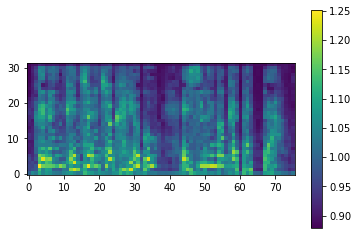

In [29]:
plt.imshow(loss[0, :, :].detach().numpy().T, origin='lower')
plt.colorbar()
plt.show()